Evaluation of the Methods of Treating Missing Values
====================================================

Concrete Problem
----------------

Given that we have a traits, says 'Leadership' that is supposed
to be determined by 5 factors. But we cannot get the value of the 
5th factor. What is the best treatment in this situation?

Model
-----
For simplicity, let assume our model as depicted below. 
 - The leadership trait is determined by 5 factors
 - Each of the factors is independent from each other
 - Each factors can take on value from 1 to 5
 - 4 of them are observed, one of them are hidden

![Model](./model.png)

In equations

\begin{equation}
\begin{split}
x_i & \sim Uniform(1, 5) \\
l &= \frac{x_1+x_2+x_3+x_4+x_5}{5}\\
\hat{l_1} &= \frac{x_1+x_2+x_3+x_4}{4}\\
\hat{l_2} &= \frac{x_1+x_2+x_3+x_4+3}{5}
\end{split}
\end{equation}

We would like to explore different ways $\hat{l_1}, \hat{l_2}$ of estimating the real
value $l$ by running some simulations

Conclusion
----------

In case you are too busy to read the detail, here are the findings:

1. The performance of either methods depend on the actual data distribution
2. When all the factors are independent from each other, both method perform almost identical with the difference that the method using mean value has lower variance.
3. When all the factors are strongly correlated to the outcome(that is if our theory is correct), then the first method is much more superior.
4. When one of the factors are not strongly correlated to the outcome(that is if some part of our theory is wrong), then the second method is much more superior.

Now the things to think about are 
a. which situation is more likely?
b. how do we make our assumption explicit so that it is refutable when new data come in

Code
----

In [63]:
import pymc3 as pm
import theano as T
import theano.tensor as tt
import matplotlib.pyplot as plt
%matplotlib inline

Case 1:
-------
all factors are independent from each other

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/catethos/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 1000/1000 [00:02<00:00, 425.54it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12468d0f0>,
      dtype=object)

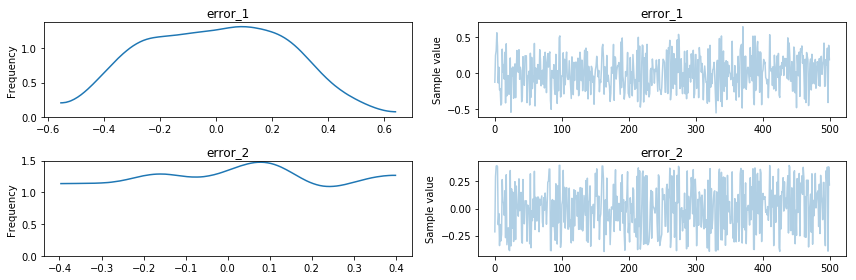

In [121]:
model = pm.Model()
with model:
    x_1 = pm.Uniform('x_1', lower=1, upper=5)
    x_2 = pm.Uniform('x_2', lower=1, upper=5)
    x_3 = pm.Uniform('x_3', lower=1, upper=5)
    x_4 = pm.Uniform('x_4', lower=1, upper=5)
    x_5 = pm.Uniform('x_5', lower=1, upper=5)
        
    l_1 = pm.Deterministic('ignored_mean', (x_1+x_2+x_3+x_4)/4)
    l_2 = pm.Deterministic('inputed_mean', (x_1+x_2+x_3+x_4+3)/5)
    real = (x_1+x_2+x_3+x_4+x_5)/5
    
    error_1 = pm.Deterministic('error_1', (real-l_1))
    error_2 = pm.Deterministic('error_2', (real-l_2))
    
with model:
    trace = pm.sample()

pm.traceplot(trace, varnames=['error_1', 'error_2'])

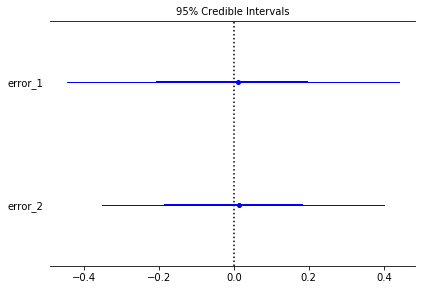

In [122]:
pm.forestplot(trace, varnames=['error_1', 'error_2'])

Interpretation
--------------
The error is almost identical, but the error using the mean value shows less variance.

Case 2:
-------

Let's say the factors are not independent from each other, and all are strongly influnced
by the fact that the person has leadership skill or not 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/catethos/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 1000/1000 [00:01<00:00, 693.60it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11badefd0>,
      dtype=object)

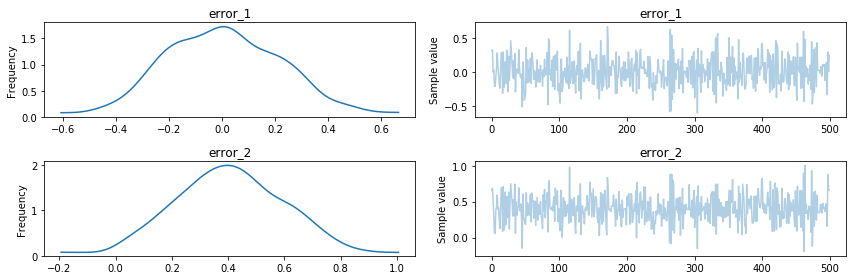

In [123]:
model = pm.Model()
with model:
    leadershipness = 1
    x_1 = pm.Normal('x_1', mu=leadershipness, sd=1)
    x_2 = pm.Normal('x_2', mu=leadershipness, sd=1)
    x_3 = pm.Normal('x_3', mu=leadershipness, sd=1)
    x_4 = pm.Normal('x_4', mu=leadershipness, sd=1)
    x_5 = pm.Normal('x_5', mu=leadershipness, sd=1)
    
    observed = pm.Deterministic('ignored_mean', (x_1+x_2+x_3+x_4)/4)
    inputed = pm.Deterministic('inputed_mean', (x_1+x_2+x_3+x_4+3)/5)
    real = (x_1+x_2+x_3+x_4+x_5)/5
    
    error_1 = pm.Deterministic('error_1', (observed-real))
    error_2 = pm.Deterministic('error_2', (inputed-real))

with model:
    trace = pm.sample()
    
pm.traceplot(trace, varnames=['error_1', 'error_2'])

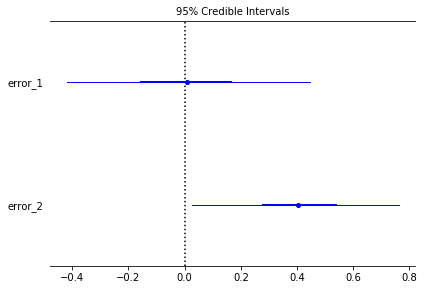

In [124]:
pm.forestplot(trace, varnames=['error_1', 'error_2'])

Interpretation
--------------

If all the factors are strongly correlated, the method using the average value will be positively biased. Whereas the method ignoring the 5th factor performs almost identical.

Case 3:
-------

Four of the factors correlate strongly with the leadership ship, but the 5th factor has no correlation at all.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/catethos/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 1000/1000 [00:01<00:00, 650.10it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123bafc18>,
      dtype=object)

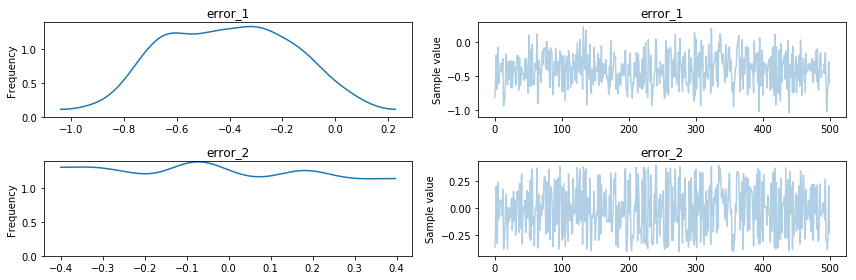

In [125]:
model = pm.Model()
with model:
    leadershipness = 1
    x_1 = pm.Normal('x_1', mu=leadershipness, sd=1)
    x_2 = pm.Normal('x_2', mu=leadershipness, sd=1)
    x_3 = pm.Normal('x_3', mu=leadershipness, sd=1)
    x_4 = pm.Normal('x_4', mu=leadershipness, sd=1)
    x_5 = pm.Uniform('x_5', lower=1, upper=5)
    
    observed = pm.Deterministic('ignored_mean', (x_1+x_2+x_3+x_4)/4)
    inputed = pm.Deterministic('inputed_mean', (x_1+x_2+x_3+x_4+3)/5)
    real = (x_1+x_2+x_3+x_4+x_5)/5
    
    error_1 = pm.Deterministic('error_1', (observed-real))
    error_2 = pm.Deterministic('error_2', (inputed-real))

with model:
    trace = pm.sample()
    
pm.traceplot(trace, varnames=['error_1', 'error_2'])

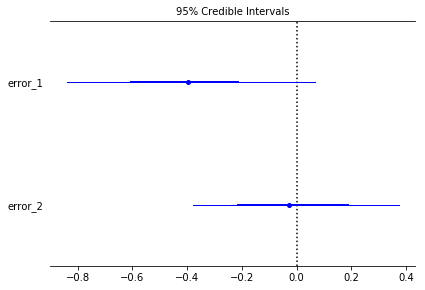

In [126]:
pm.forestplot(trace, varnames=['error_1', 'error_2'])

Interpretation
--------------

In the most unexpected case where one of the factor is not correlated strongly to the leadership skill, the first method will be negatively biased. But the second method will perform better.